# Poincaré Embeddings

In this notebook, I explore hyperbolic geometry and Poincaré embeddings, as presented by Nickel and Kiela from Facebook AI Research in [*Poincaré Embeddings for Learning Hierarchical Representations* (2017)](https://arxiv.org/pdf/1705.08039.pdf).<br>
<br>
I explore existing implementations of this Poincaré model, such as the implementation from the `gensim` library, and I attempt to apply the model to a few real datasets and evaluate whether the embeddings produce useful representations.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (6.5, 6.5)
plt.rcParams['figure.facecolor'] = 'white'
from jupyterthemes import jtplot
jtplot.style()

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

For many high dimensional datasets used in machine learning problems, such as image recognition or text analysis, it can be quite useful to find a lower dimensional embedding of the data that preserves the intrinsic structure. An embedding is a representation of the data, and it is often how an algorithm finally sees the data and learns how to make predictions. Finding a good representation is therefore crucially important, and the criteria often used to evaluate an embedding is whether the spatial similarities in the embedding space (distances for some metric) reflect the semantic or qualitative similarities in the original space.   

In symbolic data like text and graph networks, hierarchical relationships are often a central aspect of the latent structure. For example, in social networks there may be influential hub nodes, and there are dependency relationships between concepts or entities in knowledge graphs, and parent-child relationships in taxonomies of language or biological species. <br>
<br>
Embeddings in Euclidean space are generally unable to reflect these complex, higher dimensional hierarchies, and so this approach attempts to embed the data in hyperbolic space. 

## Hyperbolic Geometry and the Poincaré Ball Model

Hyperbolic geometry is a non-Euclidean geometry with constant negative curvature. The authors note the idea of hyperbolic space acting as a continuous analogue to trees, and so this allows the hyperbolic space to naturally represent hierarchies. <br>
<br>
In the graph of a tree, the number of child nodes grows exponentially as the depth of the tree increases. For a simple binary tree, at level $n$ the tree will have at most $2^n$ nodes. Considering the two dimensional plane, a tree can be embedded in hyperbolic space in a way that accurately reflects the exponential growth in this hierarchy. <br>
<br>
In hyperbolic space, the circumference of a circle of radius $r$ is equal to: <br>
$2 \pi \sinh(r)$ and the area is equal to: $2 \pi (\cosh(r) -1)$ <br>
where $\sinh r=\frac{1}{2}\left(e^{r}-e^{-r}\right)$ and $\cosh r=\frac{1}{2}\left(e^{r}+e^{-r}\right)$ <br>
so the circumference and area grow exponentially with radius $r$. <br>
<br>
However, in Euclidean space the circumference $2 \pi r$ grows linearly <br>
and the area $2 \pi r^2$ grows quadratically.

![title](hyper_tree.png)
Intuitively, the exponential growth gives hyperbolic space more room near the boundary, so that at each level the sub-trees can be laid out with similar distances between the root and leaf nodes, in a kind of fractal pattern. 

![title](dendogram.png)
In Euclidean space, the tree becomes very cluttered near the final leaf nodes and so it would take an exponentially increasing number of dimensions and time complexity to model the hierarchy.

There are many different models of hyperbolic space, but we focus on the Poincaré Ball model (in two dimensions, this is the Poincaré disk). We first consider the Euclidean open unit-ball in d-dimensions.

$$
\mathcal{B}^{d}=\left\{\boldsymbol{x} \in \mathbb{R}^{d} |\|\boldsymbol{x}\|<1\right\}
$$

The Poincaré ball in hyperbolic space is the Riemannian manifold $\left(\mathcal{B}^{d}, g_{\boldsymbol{x}}\right)$ with Riemannian metric tensor <br>

$$
g_{\boldsymbol{x}}=\left(\frac{2}{1-\|\boldsymbol{x}\|^{2}}\right)^{2} g^{E}
$$<br>
where $x \in \mathcal{B}^{d}$ and $g^{E}$ is the Euclidean metric tensor.

We have the symmetric distance function for $\boldsymbol{u}, \boldsymbol{v} \in \mathcal{B}^{d}$:

$$
d(\boldsymbol{u}, \boldsymbol{v})=\operatorname{arcosh}\left(1+2 \frac{\|\boldsymbol{u}-\boldsymbol{v}\|^{2}}{\left(1-\|\boldsymbol{u}\|^{2}\right)\left(1-\|\boldsymbol{v}\|^{2}\right)}\right)
$$

![title](poincare_disk.png)

To embed the data $x_1, ..., x_n$ in the Poincaré ball, we find <br>
$\Theta=\left\{\boldsymbol{\theta}_{i}\right\}_{i=1}^{n},$ where $\boldsymbol{\theta}_{i} \in \mathcal{B}^{d}$ <br>
<br>
The Riemannian manifold structure allows us to use gradient based optimization and find the optimal embeddings for some problem-specific loss function $\mathcal{L}(\Theta)$: <br>
<br>
$$
\Theta^{\prime} \leftarrow \underset{\Theta}{\arg \min } \mathcal{L}(\Theta) \quad \text { s.t. } \forall \theta_{i} \in \Theta :\left\|\theta_{i}\right\|<1
$$

Let $\mathcal{T}_{\theta} \mathcal{B}$ be the tangent space for some $\theta \in \mathcal{B}^d$ <br>
and let $\nabla_{R} \in \mathcal{T}_{\theta} \mathcal{B}$ be the Riemannian gradient of $\mathcal{L}(\Theta)$

We have the parameter update rule given by: <br>

$$
\boldsymbol{\theta}_{t+1}=\mathfrak{R}_{\theta_{t}}\left(-\eta_{t} \nabla_{R} \mathcal{L}\left(\boldsymbol{\theta}_{t}\right)\right)
$$ <br>
where $\mathfrak{R}_{\theta_{t}}$ is the retraction onto $\mathcal{B}^d$ and $\eta$ is the learning rate
$$
\mathfrak{R}_{\theta}(\boldsymbol{v})=\boldsymbol{\theta}+\boldsymbol{v}
$$

We'd like to write the Riemannian gradient in terms of the Euclidean gradient where <br>
<br>
$$
\nabla_{E}=\frac{\partial \mathcal{L}(\boldsymbol{\theta})}{\partial d(\boldsymbol{\theta}, \boldsymbol{x})} \frac{\partial d(\boldsymbol{\theta}, \boldsymbol{x})}{\partial \boldsymbol{\theta}}
$$ <br>
and we assume the problem-specific loss function $\mathcal{L}(\boldsymbol{\theta}$ is known

Then, to find the partial derivatives of the Poincaré distance, we define the following:
$$
\alpha=1-\|\boldsymbol{\theta}\|^{2}
$$
$$
\beta=1-\|\boldsymbol{x}\|^{2}
$$
$$
\gamma=1+\frac{2}{\alpha \beta}\|\boldsymbol{\theta}-\boldsymbol{x}\|^{2}
$$
<br>
and we can write the partial derivative<br>
<br>
$$
\frac{\partial d(\boldsymbol{\theta}, \boldsymbol{x})}{\partial \boldsymbol{\theta}}=\frac{4}{\beta \sqrt{\gamma^{2}-1}}\left(\frac{\|\boldsymbol{x}\|^{2}-2\langle\boldsymbol{\theta}, \boldsymbol{x}\rangle+ 1}{\alpha^{2}} \boldsymbol{\theta}-\frac{\boldsymbol{x}}{\alpha}\right)
$$

Finally, we write the update rule in terms of Euclidean gradient $\nabla_{E}$ of the <br>
loss function and set $\epsilon$ to constrain the embeddings within the Poincaré ball: <br>
<br>
$$
\operatorname{proj}(\boldsymbol{\theta})=\left\{\begin{array}{ll}{\boldsymbol{\theta} /\|\boldsymbol{\theta}\|-\varepsilon} & {\text { if }\|\boldsymbol{\theta}\| \geq 1} \\ {\boldsymbol{\theta}} & {\text { otherwise }}\end{array}\right.
$$ <br>
and using partial derivatives of Poincaré distance we have:<br>
<br>
$$
\boxed{\boldsymbol{\theta}_{t+1} \leftarrow \operatorname{proj}\left(\boldsymbol{\theta}_{t}-\eta_{t} \frac{\left(1-\left\|\boldsymbol{\theta}_{t}\right\|^{2}\right)^{2}}{4} \nabla_{E}\right)}
$$

## Implementing the  Poincaré Model

First, let's write a function to compute the Poincaré distance

In [4]:
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

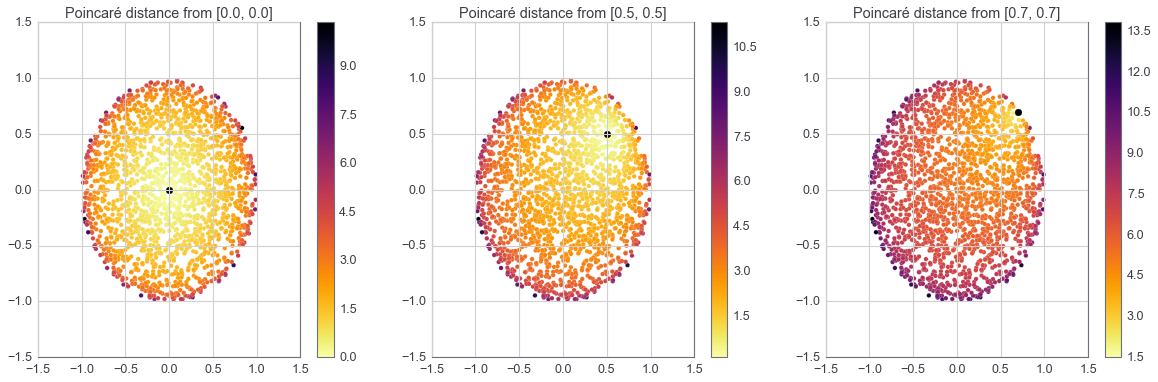

In [5]:
# plot unit circle in R^2
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 3, 1)

# sample within unit circle in R^2
n = 2000
theta = np.random.uniform(0, 2*np.pi, n)
u = np.random.uniform(0, 1, n)
r = np.sqrt(u)
X = np.array([r * np.cos(theta), r * np.sin(theta)]).T
i = np.random.choice(n)

xi = [0.0, 0.0]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im)

ax = fig.add_subplot(1, 3, 2)
xi = [0.5, 0.5]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im);

ax = fig.add_subplot(1, 3, 3)
xi = [0.7, 0.7]
dist_xi = [poincare_dist(xi, x) for x in X]
im = ax.scatter(X[:,0], X[:,1], s=20, c=dist_xi, cmap='inferno_r', edgecolors='white')
ax.scatter(xi, xi, s =50, c='black')
ax.set_title('Poincaré distance from ' + str(xi))
plt.colorbar(im)
plt.show();

In [6]:
import os
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'custom_style.css',
 'dendogram.png',
 'escher.jpg',
 'escher2.jpg',
 'hyper_tree.png',
 'mammals_filter',
 'mammals_filter.txt',
 'mammals_filtered.txt',
 'mammal_closure.csv',
 'noun_closure.csv',
 'poincare.ipynb',
 'poincare_disk.png',
 'test_vectors',
 'wordnet_mammal_hypernyms.tsv']

In [7]:
import re
import pandas
from nltk.corpus import wordnet as wn
from tqdm import tqdm
try:
    wn.all_synsets
except LookupError as e:
    import nltk
    nltk.download('wordnet')

# make sure each edge is included only once
edges = set()
for synset in tqdm(wn.all_synsets(pos='n')):
    # write the transitive closure of all hypernyms of a synset to file
    for hyper in synset.closure(lambda s: s.hypernyms()):
        edges.add((synset.name(), hyper.name()))

    # also write transitive closure for all instances of a synset
    for instance in synset.instance_hyponyms():
        for hyper in instance.closure(lambda s: s.instance_hypernyms()):
            edges.add((instance.name(), hyper.name()))
            for h in hyper.closure(lambda s: s.hypernyms()):
                edges.add((instance.name(), h.name()))

nouns = pandas.DataFrame(list(edges), columns=['id1', 'id2'])
nouns['weight'] = 1

# Extract the set of nouns that have "mammal.n.01" as a hypernym
mammal_set = set(nouns[nouns.id2 == 'mammal.n.01'].id1.unique())
mammal_set.add('mammal.n.01')

# Select relations that have a mammal as hypo and hypernym
mammals = nouns[nouns.id1.isin(mammal_set) & nouns.id2.isin(mammal_set)]

with open('mammals_filter.txt', 'r') as fin:
    filt = re.compile(f'({"|".join([l.strip() for l in fin.readlines()])})')


filtered_mammals = mammals[~mammals.id1.str.cat(' ' + mammals.id2).str.match(filt)]

nouns.to_csv('noun_closure.csv', index=False)
filtered_mammals.to_csv('mammal_closure.csv', index=False)

<bound method WordNetCorpusReader.all_synsets of <WordNetCorpusReader in 'C:\\Users\\dreww\\AppData\\Roaming\\nltk_data\\corpora\\wordnet'>>

82115it [00:12, 6823.97it/s]


To implement the poincaré model, we need to find both terms in this gradient function so we can perform gradient based optimization to find the optimal embeddings <br>

$$
\nabla_{E}=\frac{\partial \mathcal{L}(\boldsymbol{\theta})}{\partial d(\boldsymbol{\theta}, \boldsymbol{x})} \frac{\partial d(\boldsymbol{\theta}, \boldsymbol{x})}{\partial \boldsymbol{\theta}}
$$

In WORDNET, we assume we have a directed acyclic graph with hypernymy relations $\mathcal{D}=\{(u, v)\}$ <br>
<br>
Loss function for WORDNET taxonomies: <br>
$$
\mathcal{L}(\Theta)=\sum_{(u, v) \in \mathcal{D}} \log \frac{e^{-d(\boldsymbol{u}, \boldsymbol{v})}}{\sum_{\boldsymbol{v}^{\prime} \in \mathcal{N}(u)} e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}
$$ <br>
where we have negative examples for u:
$$
\mathcal{N}(u)=\{v |(u, v) \notin \mathcal{D}\} \cup\{u\}
$$

We can write the loss function as: <br>
<br>
$$\log {e^{-d(\boldsymbol{u}, \boldsymbol{v})}} - \log{\sum_{\boldsymbol{v}^{\prime} \in \mathcal{N}(u)} e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}$$ <br>

$$ -d(\boldsymbol{u}, \boldsymbol{v}) - \log{\sum_{\boldsymbol{v}^{\prime} \in \mathcal{N}(u)} e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}$$ <br>
with partial derivative: <br>

$$\frac{\partial \mathcal{L}(\boldsymbol{\theta})}{\partial d(\boldsymbol{\theta}, \boldsymbol{x})} = -1$$

We also have the partial derivative of the poincare distance from before: <br>
<br>
$$
\frac{\partial d(\boldsymbol{\theta}, \boldsymbol{x})}{\partial \boldsymbol{\theta}}=\frac{4}{\beta \sqrt{\gamma^{2}-1}}\left(\frac{\|\boldsymbol{x}\|^{2}-2\langle\boldsymbol{\theta}, \boldsymbol{x}\rangle+ 1}{\alpha^{2}} \boldsymbol{\theta}-\frac{\boldsymbol{x}}{\alpha}\right)
$$

And the final gradient expression (with respect to u for relation (u, v)): <br>
<br>
$$\nabla_{E} = - \frac{\partial d(\boldsymbol{\theta}, \boldsymbol{x})}{\partial \boldsymbol{\theta}}$$

In [7]:
mammal = pd.read_csv('mammal_closure.csv')
len(np.unique(list(mammal.id1.values) + list(mammal.id2.values)))
mammal_relations = [[mammal.id1[i], mammal.id2[i]] for i in range(len(mammal))]
len([rel for rel in mammal_relations if rel[0]==rel[1]])
mammal_relations[:10]

1180

0

[['wether.n.01', 'sheep.n.01'],
 ['red_wolf.n.01', 'canine.n.02'],
 ['chiacoan_peccary.n.01', 'placental.n.01'],
 ['siamang.n.01', 'placental.n.01'],
 ['remount.n.01', 'mammal.n.01'],
 ['miniature_pinscher.n.01', 'mammal.n.01'],
 ['barren_ground_caribou.n.01', 'placental.n.01'],
 ['sennenhunde.n.01', 'canine.n.02'],
 ['dormouse.n.01', 'rodent.n.01'],
 ['water_buffalo.n.01', 'bovid.n.01']]

In [180]:
import csv
path = "wordnet_mammal_hypernyms.tsv"
def load_data(file_path, delim="\t"):
    data = []
    with open(file_path, "r") as f:
        reader = csv.reader(f, delimiter=delim)
        for i, line in enumerate(reader):
            data.append(line)
    return data
relations = load_data(path)
relations[:5]

[['kangaroo.n.01', 'marsupial.n.01'],
 ['domestic_goat.n.01', 'even-toed_ungulate.n.01'],
 ['rock_squirrel.n.01', 'ground_squirrel.n.02'],
 ['vizsla.n.01', 'dog.n.01'],
 ['dandie_dinmont.n.01', 'mammal.n.01']]

In [8]:
unique_nodes = np.unique([item for sublist in mammal_relations for item in sublist])
def init_embeddings(n, dim, low=-0.001, high=0.001):
    theta_init = np.random.uniform(low, high, size=(n, dim))
    return theta_init
emb = init_embeddings(len(unique_nodes), 2)
len(emb)
len(mammal_relations)
emb_dict = dict(zip(unique_nodes, emb))
{k: emb_dict[k] for k in list(emb_dict)[:10]}

1180

6540

{'aardvark.n.01': array([ 1.53598367e-07, -3.93589096e-04]),
 'aardwolf.n.01': array([-0.00027847,  0.00028297]),
 'aberdeen_angus.n.01': array([ 0.00015205, -0.00090076]),
 'abrocome.n.01': array([ 0.00019202, -0.00071982]),
 'abyssinian.n.01': array([ 0.00020245, -0.0006167 ]),
 'addax.n.01': array([-0.00076522,  0.0004369 ]),
 'aegyptopithecus.n.01': array([-0.00028516, -0.00071717]),
 'affenpinscher.n.01': array([-0.00051145, -0.00064456]),
 'affirmed.n.01': array([-0.00061557, -0.00098919]),
 'afghan_hound.n.01': array([-3.31826377e-05, -2.59691988e-04])}

In [9]:
def negative_sample(data, u, n_samples):
    positives = [x[1] for x in data if x[0] == u]
    negatives = np.array([x for x in unique_nodes if x not in positives])
    random_ix = np.random.permutation(len(negatives))[:n_samples]
    neg_samples = [[u, x] for x in negatives[random_ix]]
    neg_samples.append([u,u])
    return neg_samples
negative_sample(mammal_relations, 'kangaroo.n.01', 4)

[['kangaroo.n.01', 'pony.n.01'],
 ['kangaroo.n.01', 'bengal_tiger.n.01'],
 ['kangaroo.n.01', 'seal.n.09'],
 ['kangaroo.n.01', 'macaque.n.01'],
 ['kangaroo.n.01', 'kangaroo.n.01']]

#### gradients and loss function

We need gradients with respect to the negative samples as well. <br>
<br>
From our loss function we had:<br>

$$ -d(\boldsymbol{u}, \boldsymbol{v}) - \log{\sum_{\boldsymbol{v}^{\prime} \in \mathcal{N}(u)} e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}$$

and we can use a fact about the log sum exp function<br>

$$
\operatorname{LSE}\left(z_{1}, \ldots, z_{n}\right)=\log \left(\exp \left(z_{1}\right)+\cdots+\exp \left(z_{n}\right)\right)
$$ <br>
$$
\partial_{i} L S E(\mathbf{x})=\exp x_{i} /\left(\sum_{i} \exp x_{i}\right)
$$
<br>
to get gradient of the loss w.r.t negative sample <br>

$$
- \frac {e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}{\sum_{\boldsymbol{v}^{\prime} \in \mathcal{N}(u)} e^{-d\left(\boldsymbol{u}, \boldsymbol{v}^{\prime}\right)}}
$$


In [10]:
eps = 1e-5
def partial_d(theta, x):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

test_arr = np.array([np.random.uniform(-eps, eps, size=(1,2))])
for arr in np.random.uniform(-eps, eps, size=(100, 2)):
    if partial_d(test_arr, arr).all() == 0:
        print('instability error')

In [11]:
def proj(theta):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta
test_proj = norm(proj(np.random.uniform(-2, 2, size=(100, 2))), axis=1) >= 1
test_proj.any()
proj(np.array([0.9,0.9]))

def update(u, lr, grad, embeddings, test=False):
    theta = embeddings[u]
    step = 1/4 * lr*(1 - norm(theta)**2)**2 * grad
    embeddings[u] = proj(theta - step)
    if test:
        if norm(proj(theta - step) < norm(theta)):
            print('updating '+u+' closer to origin')
        else:
            print('updating ' +u+ ' away from origin')
    return

False

array([0.70709678, 0.70709678])

In [241]:
emb_dict = dict(zip(unique_nodes, emb))

In [12]:
import time
num_neg = 10
def train_poincare(relations, lr=0.001, num_epochs=10):
    for i in range(num_epochs):
        start = time.time()
        for relation in relations:
            u, v = relation[0], relation[1]
            if u == v:
                continue
            # embedding vectors (theta, x) for relation (u, v)
            theta, x = emb_dict[u], emb_dict[v]
            # embedding vectors v' in sample negative relations (u, v')
            neg_relations = [x[1] for x in negative_sample(relations, u, num_neg)]
            neg_embed = np.array([emb_dict[x] for x in neg_relations])
            # find partial derivatives of poincare distance
            dd_theta = partial_d(theta, x) 
            dd_x = partial_d(x, theta)
            # find partial derivatives of loss function
            dloss_theta = -1
            dloss_x = 1
            grad_theta = dloss_theta * dd_theta
            grad_x = dloss_x * dd_x
            update(u, lr, grad_theta, emb_dict)
            update(v, lr, grad_x, emb_dict)
            # find gradients for negative samples
            neg_exp_dist = np.array([np.exp(-poincare_dist(theta, v_prime)) for v_prime in neg_embed])
            Z = neg_exp_dist.sum(axis=0)
            for vprime in neg_relations:
                dd_vprime = partial_d(emb_dict[vprime], theta)
                dd_u = partial_d(theta, emb_dict[vprime])
                dloss_vprime = -np.exp(-poincare_dist(emb_dict[vprime], theta)) / Z
                dloss_u = -np.exp(-poincare_dist(theta, emb_dict[vprime])) / Z
                grad_vprime = dd_vprime * dloss_vprime
                grad_u = dd_u * dloss_u
                update(vprime, lr, grad_vprime, emb_dict)
                update(u, lr, grad_u, emb_dict)
        print('COMPLETED EPOCH ', i+1)
        print('---------- total seconds: ', time.time() - start)

In [17]:
train_poincare(mammal_relations, lr=0.01, num_epochs=40)

COMPLETED EPOCH  1
---------- total seconds:  25.110493183135986
COMPLETED EPOCH  2
---------- total seconds:  24.840006351470947
COMPLETED EPOCH  3
---------- total seconds:  24.66980004310608
COMPLETED EPOCH  4
---------- total seconds:  25.20946216583252
COMPLETED EPOCH  5
---------- total seconds:  24.539266109466553
COMPLETED EPOCH  6
---------- total seconds:  24.720669269561768
COMPLETED EPOCH  7
---------- total seconds:  24.760849952697754
COMPLETED EPOCH  8
---------- total seconds:  26.25095272064209
COMPLETED EPOCH  9
---------- total seconds:  25.675355434417725
COMPLETED EPOCH  10
---------- total seconds:  25.499465942382812
COMPLETED EPOCH  11
---------- total seconds:  25.99953293800354
COMPLETED EPOCH  12
---------- total seconds:  24.763733386993408
COMPLETED EPOCH  13
---------- total seconds:  25.49697780609131
COMPLETED EPOCH  14
---------- total seconds:  26.095805644989014
COMPLETED EPOCH  15
---------- total seconds:  25.86736297607422
COMPLETED EPOCH  16
-----

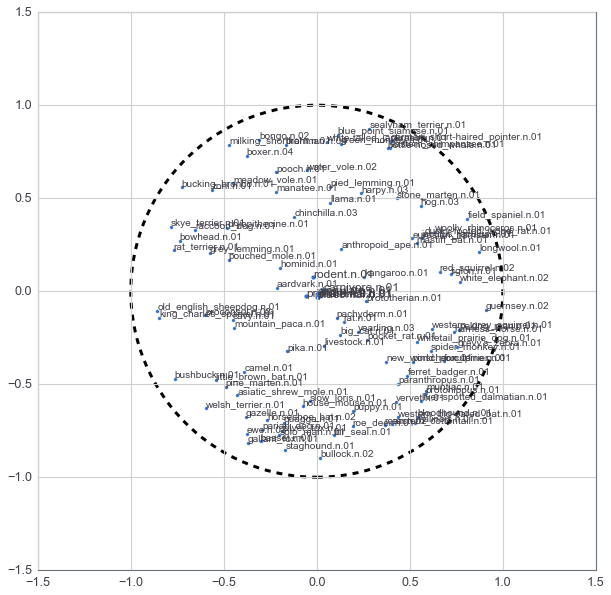

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, linestyle='--')
_ = ax.add_patch(circ)

keys = list(emb_dict.keys())
for i in np.random.permutation(len(list(emb_dict.keys())))[:100]:
    _ = ax.scatter(emb_dict[keys[i]][0], emb_dict[keys[i]][1], s=12)
    _ = ax.text(emb_dict[keys[i]][0], emb_dict[keys[i]][1]+0.01, s=keys[i])
groups = ['mammal.n.01', 'carnivore.n.01', 'rodent.n.01', 'primate.n.02', 'dog.n.01',
         'ungulate.n.01', 'placental.n.01']
for key in groups:
    _ = ax.scatter(emb_dict[key][0], emb_dict[key][1])
    _ = ax.text(emb_dict[key][0], emb_dict[key][1], s=key, size=12);

### autograd

In [497]:
try:
    from autograd import grad  # Only required for optionally verifying gradients while training
    from autograd import numpy as grad_np
    AUTOGRAD_PRESENT = True
except ImportError:
    AUTOGRAD_PRESENT = False

In [509]:
#@staticmethod
def _loss_fn(matrix, regularization_coeff=1.0):
    """Computes loss value.
    Parameters
    ----------
    matrix : numpy.array
        Array containing vectors for u, v and negative samples, of shape (2 + negative_size, dim).
    regularization_coeff : float, optional
        Coefficient to use for l2-regularization
    Returns
    -------
    float
        Computed loss value.
    Warnings
    --------
    Only used for autograd gradients, since autograd requires a specific function signature.
    """
    vector_u = matrix[0]
    vectors_v = matrix[1:]
    euclidean_dists = grad_np.linalg.norm(vector_u - vectors_v, axis=1)
    norm = grad_np.linalg.norm(vector_u)
    all_norms = grad_np.linalg.norm(vectors_v, axis=1)
    poincare_dists = grad_np.arccosh(
        1 + 2 * (
            (euclidean_dists ** 2) / ((1 - norm ** 2) * (1 - all_norms ** 2))
        )
    )
    exp_negative_distances = grad_np.exp(-poincare_dists)
    regularization_term = regularization_coeff * grad_np.linalg.norm(vectors_v[0]) ** 2
    return -grad_np.log(exp_negative_distances[0] / (exp_negative_distances.sum())) + regularization_term

In [510]:
u = relations[0][0]
v = relations[0][1]
#grad_loss(u, v)

theta = embedding_dict[u]
x = embedding_dict[v]
negatives = negative_sample(relations, u, num_negative)
neg_v = np.array([embedding_dict[sample[1]] for sample in negatives])
vector_u = theta
vectors_v = np.vstack((x,neg_v))
matrix = np.vstack((vector_u, vectors_v))
matrix

autograd_loss = grad(_loss_fn)
autograd_loss(matrix)

array([[ 5.74716018e-04,  6.97527660e-04],
       [ 3.37701305e-04,  8.66555445e-04],
       [ 3.83829613e-04,  6.74802549e-04],
       [-1.20765268e-04,  8.85790337e-05],
       [ 4.72973304e-04, -4.61430935e-04],
       [ 5.38820781e-04,  6.18095958e-04],
       [ 3.76438857e-04, -4.99407927e-05]])

In [512]:
grad_loss(u, v)

kangaroo.n.01 marsupial.n.01
THETA: [0.00057472 0.00069753] X: [0.0003377  0.00086656]
kangaroo.n.01 polecat.n.02
THETA: [0.00057472 0.00069753] X: [ 7.51517834e-04 -1.36311248e-05]
kangaroo.n.01 chacma.n.01
THETA: [0.00057472 0.00069753] X: [2.45251935e-05 6.84987306e-05]
kangaroo.n.01 sivapithecus.n.01
THETA: [0.00057472 0.00069753] X: [-0.00053263  0.0006443 ]
kangaroo.n.01 asiatic_black_bear.n.01
THETA: [0.00057472 0.00069753] X: [-8.05125842e-05 -6.98825689e-04]
kangaroo.n.01 river_otter.n.01
THETA: [0.00057472 0.00069753] X: [ 0.00074298 -0.00099229]
kangaroo.n.01 marsupial.n.01
THETA: [0.00057472 0.00069753] X: [0.0003377  0.00086656]


array([[ 1.30209061, -0.92858948],
       [ 0.09659354, -0.3885339 ],
       [-0.26352846, -0.30129007],
       [-0.39959882, -0.01920689],
       [-0.1697981 , -0.36185528],
       [ 0.03959191, -0.39762247]])

## gensim

In [513]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
file_path = "wordnet_mammal_hypernyms.tsv"
relations = PoincareRelations(file_path=file_path, delimiter='\t')
model = PoincareModel(train_data=relations, size=2)
model.train(epochs=10, print_every=500)

In [514]:
model.kv.save_word2vec_format('test_vectors')
PoincareKeyedVectors.load_word2vec_format('test_vectors')

In [515]:
model.kv.descendants('mammal.n.01')
model.kv.ancestors('dog.n.01')

['round-tailed_muskrat.n.01',
 'mole_rat.n.02',
 'sand_rat.n.01',
 'chinchilla.n.03',
 'coypu.n.01']

['corgi.n.01',
 'puppy.n.01',
 'miniature_poodle.n.01',
 'keeshond.n.01',
 'pug.n.01',
 'brown_hyena.n.01',
 'red_fox.n.02',
 'grey_fox.n.01',
 'striped_hyena.n.01',
 'jackal.n.01',
 'hyena.n.01',
 'aardwolf.n.01',
 'carnivore.n.01',
 'bassarisk.n.01',
 'kinkajou.n.01',
 'coati.n.01',
 'lesser_panda.n.01',
 'procyonid.n.01',
 'giant_panda.n.01',
 'tusker.n.01',
 'armadillo.n.01',
 'ground_sloth.n.01',
 'two-toed_sloth.n.01',
 'rock_hyrax.n.01',
 'asiatic_shrew_mole.n.01',
 'pangolin.n.01',
 'hyrax.n.01']

In [158]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()